# 基于AES_En_De_PYNQ.ipynb

## Import libraries

In [1]:
from pynq import Overlay

## Download the Image Processing IP bitstream

In [2]:
AES_En_De_overlay = Overlay("./bitstream/AES_En_De.bit")

In [3]:
AES_En_De_overlay?
AES_En_De_overlay.ip_dict

{'AES_En_De_0': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0xb03033f0>,
  'driver': pynq.overlay.DefaultIP,
  'fullpath': 'AES_En_De_0',
  'gpio': {},
  'interrupts': {},
  'mem_id': 's_axi_AXILiteS',
  'parameters': {'C_S_AXI_AXILITES_ADDR_WIDTH': '6',
   'C_S_AXI_AXILITES_BASEADDR': '0x43C00000',
   'C_S_AXI_AXILITES_DATA_WIDTH': '32',
   'C_S_AXI_AXILITES_HIGHADDR': '0x43C0FFFF',
   'Component_Name': 'AES_En_De_block_design_AES_En_De_0_0',
   'EDK_IPTYPE': 'PERIPHERAL',
   'II': 'x',
   'clk_period': '10',
   'combinational': '0',
   'latency': 'undef',
   'machine': '64'},
  'phys_addr': 1136656384,
  'registers': {'CTRL': {'access': 'read-write',
    'address_offset': 0,
    'description': 'Control signals',
    'fields': {'AP_DONE': {'access': 'read-only',
      'bit_offset': 1,
      'bit_width': 1,
      'description': 'Control signals'},
     'AP_IDLE': {'access': 'read-only',
      'bit_offset': 2,
      'bit_width': 1,
      'description': 'Contro

## Create an MMIO instance to Access AES_En_D

In [4]:
from pynq import MMIO
AES_En_D_address = AES_En_De_overlay.ip_dict['AES_En_De_0']['phys_addr']
addr_range = 0x40
mmio = MMIO(AES_En_D_address, addr_range)

#### 设计一个函数，16个biytes in 去加密，16个bytes 输出加密结果

In [5]:
def call_AES_En_De(input_16_bytes, key_bytes_object, en_or_decryption):
#     while( not( mmio.read(0x00) & 0x8) ): # 等待 bit3 AP_READY，表示可以接收数据
#         pass
    print(mmio.read(0x00)) # & 0x8
    
    mmio.write(16, input_16_bytes )  # plain/cipher text，  bytes object  b"",纯"" 是string object
    
    mmio.write(48, key_bytes_object )  # key  # 写可以 写一片连续地址，读无法读一片连续地址
    mmio.write(32,16 ) # 明文长度，以char为单位 in_char_len[0]
    mmio.write(36, en_or_decryption ) # 0加密 1解密             in_char_len[1]
    mmio.write(40,0 ) # 调试信息                in_char_len[2]
    
    mmio.write(0x00, 0x1) # 往 AP_START 位写1 控制AES开始
    
#     while( not( mmio.read(0x00) & 0x2) ): # 等待 bit1 AP_DONE，表示IP 处理完毕，可以读结果
#         pass
    
    print(mmio.read(0x00)) # & 0x2
    
    bytes_arrray = bytearray( (mmio.read(16)).to_bytes(4, 'little',signed=False) )
    bytes_arrray.extend( bytearray(  (mmio.read(20)).to_bytes(4, 'little',signed=False) ) )
    bytes_arrray.extend( bytearray( (mmio.read(24)).to_bytes(4, 'little',signed=False) ) )
    bytes_arrray.extend( bytearray( (mmio.read(28)).to_bytes(4, 'little',signed=False) ) ) 
    
    return bytes_arrray
#     return [ bytearray(mmio.read(16)).to_bytes(4, 'little',signed=False), (mmio.read(20)).to_bytes(4, 'little',signed=False), \
#             (mmio.read(24)).to_bytes(4, 'little',signed=False), (mmio.read(28)).to_bytes(4, 'little',signed=False)]

In [32]:
help(bytearray.)

Help on method_descriptor:

expandtabs(...)
    B.expandtabs(tabsize=8) -> copy of B
    
    Return a copy of B where all tab characters are expanded using spaces.
    If tabsize is not given, a tab size of 8 characters is assumed.



#### 测试 调用 写好的函数

In [6]:
# help(int)

plain_text = "abcdefghijklmnop"
plain_bytes_object = plain_text.encode("ascii")

key_text = "hello_world_aes_"
key_bytes_object = key_text.encode("ascii")

cipher = call_AES_En_De(plain_bytes_object, key_bytes_object,0)
print( cipher )

cipher = bytes( cipher )
plain = call_AES_En_De(cipher, key_bytes_object,1)
print( plain )

4
6
bytearray(b'\xe2\x95\x99\xb5+\xa3U\xddZ\xc4\xad\x00R\xe9\xfeT')
4
1
bytearray(b'abcdefghijklmnop')


## Create an Image object using PIL in SW
We will load image from the SD card and create a PIL Image object.

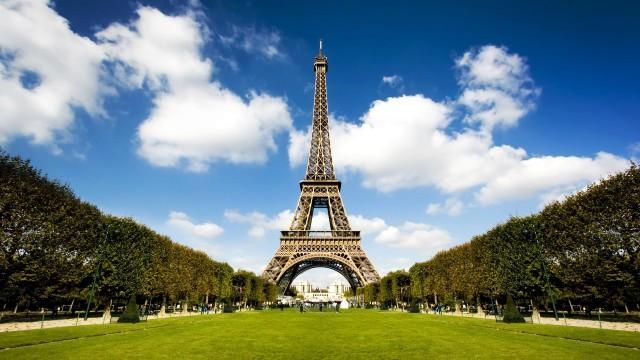

Image size: 640x360 pixels.


In [7]:
from PIL import Image
import numpy as np
from IPython.display import display

image_path = "./images/paris.jpg"
original_image = Image.open(image_path)
display(original_image)

pic_width, pic_height = original_image.size
print("Image size: {}x{} pixels.".format(pic_width, pic_height))

In [34]:
# help(original_image)  # getdata   To convert it to an ordinary sequence (e.g. for printing), use **list(im.getdata())**.
# dir(original_image)
# help(original_image.tobytes)
# help(original_image.tostring)   # tostring() has been removed. Please call tobytes() instead.
# help(original_image.frombytes)

## Get Image bytes object

### 测试
把图像 转成 bytes ，因为bytes是tuple 不能修改，转成 bytearray，来修改

因为 Image.frombytes 需要bytes 输入，所以 再把 bytearray 转成 bytes

177
0


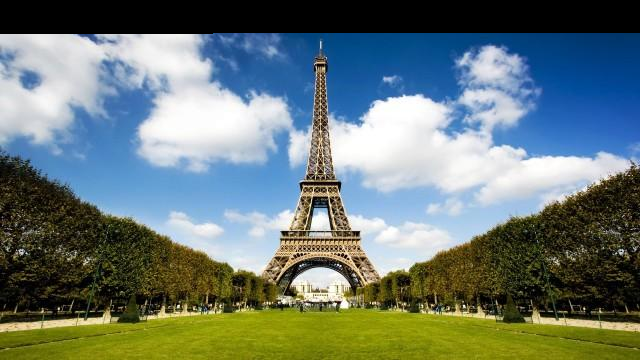

In [54]:
image_bytes_object = original_image.tobytes()
len(original_image.tobytes())

encryption_image_bytes_object = bytes(len(original_image.tobytes()))
len(encryption_image_bytes_object)

encryption_image_bytes_object = image_bytes_object

encryption_image_bytes_object = bytearray(image_bytes_object)
print(encryption_image_bytes_object[0])

for i in range(0,64000,1):
    encryption_image_bytes_object[i] = 0

print(encryption_image_bytes_object[0])

encryption_image_bytes_object = bytes(encryption_image_bytes_object)
encryption_image = Image.frombytes('RGB',(pic_width, pic_height ),encryption_image_bytes_object)
display(encryption_image)

In [35]:
# help(Image.new)
# help(Image.frombytes)
# help(Image.open)
# help(bytes)

## 加密 图像
每次加密16bytes，然后把加密结果存起来，组成一幅图像

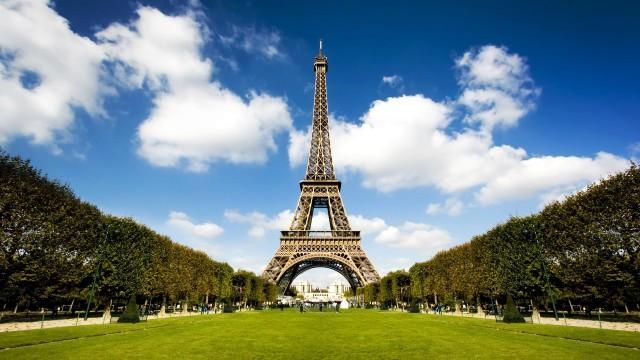

691200

In [8]:

# original_image = original_image.convert('L')

display(original_image) # RGB 太大，先灰度看看

image_bytes_object = original_image.tobytes()
bytes_of_image  = len(image_bytes_object) 
# bytes_of_image  = bytes_of_image + 16 - bytes_of_image  % 16   # 假如 不是 16的整数，那就凑够 16的整数
bytes_of_image


### 测试

In [54]:
i =0;
print(image_bytes_object[0:64])
while( i < 64 ):
    print(i)
    print(image_bytes_object[i:i+16])
    i = i+16;

b'\xbb\xb7\xb2\xb1\xb5\xbb\xbf\xc2\xc2\xc7\xcd\xcf\xce\xcd\xce\xcf\xd4\xd3\xd3\xd3\xd4\xd6\xd7\xd8\xd8\xda\xdc\xdc\xdc\xdd\xe0\xe3\xe0\xe0\xe1\xe2\xe2\xe1\xe1\xe0\xdf\xdb\xd8\xda\xda\xd3\xca\xc3\xb0\x8ffLA=98:8434443'
0
b'\xbb\xb7\xb2\xb1\xb5\xbb\xbf\xc2\xc2\xc7\xcd\xcf\xce\xcd\xce\xcf'
16
b'\xd4\xd3\xd3\xd3\xd4\xd6\xd7\xd8\xd8\xda\xdc\xdc\xdc\xdd\xe0\xe3'
32
b'\xe0\xe0\xe1\xe2\xe2\xe1\xe1\xe0\xdf\xdb\xd8\xda\xda\xd3\xca\xc3'
48
b'\xb0\x8ffLA=98:8434443'


## 加密 图像 16bytes 依次 传进去加密

In [9]:
import time
i = 0;
encryption_image_bytes_arrray = bytearray()

start = time.time()

while( i < bytes_of_image ):
#     print(i)
    encryption_image_bytes_arrray.extend( call_AES_En_De((image_bytes_object[i:i+16]), key_bytes_object,0)  )
    i = i+16;

print(i)    
end = time.time()
print("加密所用时长 " + str (end - start) )

6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
6
4
1
6
1
6
1
6
1
6
1


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6
1
6


### 画一下，加密图片

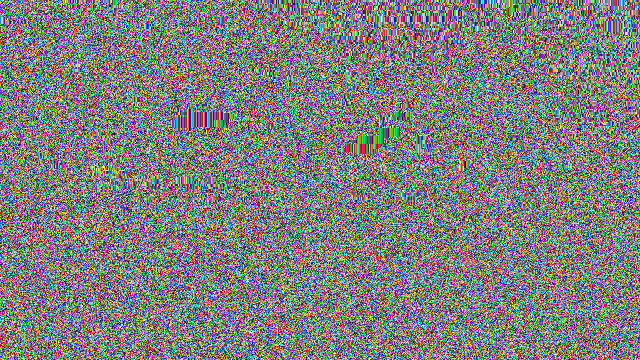

In [10]:
encryption_image_bytes_arrray = bytes( encryption_image_bytes_arrray ) # 转成bytes，Image.frombytes 不支持从 bytearray转成图片

# encryption_image = Image.frombytes('L',(pic_width, pic_height ),encryption_image_bytes_arrray)
encryption_image = Image.frombytes('RGB',(pic_width, pic_height ),encryption_image_bytes_arrray)

display(encryption_image)

## 解密 图像
每次 16bytes，然后把 结果存起来，组成一幅图像

In [11]:
i = 0;
decryption_image_bytes_arrray = bytearray()

start = time.time()

while( i < bytes_of_image ):
#     print(i)
    decryption_image_bytes_arrray.extend( call_AES_En_De( ( encryption_image_bytes_arrray [i:i+16]), key_bytes_object, 1 )  )
    i = i+16;

print(i)
end = time.time()
print("解密所用时长 " + str (end - start) )

0
6
1
16
6
1
32
6
1
48
6
1
64
6
1
80
6
1
96
6
1
112
6
1
128
6
1
144
6
1
160
6
1
176
6
1
192
6
1
208
6
1
224
6
1
240
6
1
256
6
1
272
6
1
288
6
1
304
6
1
320
6
1
336
6
1
352
6
1
368
6
1
384
6
1
400
6
1
416
6
1
432
6
1
448
6
1
464
6
1
480
6
1
496
6
1
512
6
1
528
6
1
544
6
1
560
6
1
576
6
1
592
6
1
608
6
1
624
6
1
640
6
1
656
6
1
672
6
1
688
6
1
704
6
1
720
6
1
736
6
1
752
6
1
768
6
1
784
6
1
800
6
1
816
6
1
832
6
1
848
6
1
864
6
1
880
6
1
896
6
1
912
6
1
928
6
1
944
6
1
960
6
1
976
6
1
992
6
1
1008
6
1
1024
6
1
1040
6
1
1056
6
1
1072
6
1
1088
6
1
1104
6
1
1120
6
1
1136
6
1
1152
6
1
1168
6
1
1184
6
1
1200
6
1
1216
6
1
1232
6
1
1248
6
1
1264
6
1
1280
6
1
1296
6
1
1312
6
1
1328
6
1
1344
6
1
1360
6
1
1376
6
1
1392
6
1
1408
6
1
1424
6
1
1440
6
1
1456
6
1
1472
6
1
1488
6
1
1504
6
1
1520
6
1
1536
6
1
1552
6
1
1568
6
1
1584
6
1
1600
6
1
1616
6
1
1632
6
1
1648
6
1
1664
6
1
1680
6
1
1696
6
1
1712
6
1
1728
6
1
1744
6
1
1760
6
1
1776
6
1
1792
6
1
1808
6
1
1824
6
1
1840
6
1
1856
6
1
1872
6
1
1888
6
1


1
14592
6
1
14608
6
1
14624
6
1
14640
6
1
14656
6
1
14672
6
1
14688
6
1
14704
6
1
14720
6
1
14736
6
1
14752
6
1
14768
6
1
14784
6
1
14800
6
1
14816
6
1
14832
6
1
14848
6
1
14864
6
1
14880
6
1
14896
6
1
14912
6
1
14928
6
1
14944
6
1
14960
6
1
14976
6
1
14992
6
1
15008
6
1
15024
6
1
15040
6
1
15056
6
1
15072
6
1
15088
6
1
15104
6
1
15120
6
1
15136
6
1
15152
6
1
15168
6
1
15184
6
1
15200
6
1
15216
6
1
15232
6
1
15248
6
1
15264
6
1
15280
6
1
15296
6
1
15312
6
1
15328
6
1
15344
6
1
15360
6
1
15376
6
1
15392
6
1
15408
6
1
15424
6
1
15440
6
1
15456
6
1
15472
6
1
15488
6
1
15504
6
1
15520
6
1
15536
6
1
15552
6
1
15568
6
1
15584
6
1
15600
6
1
15616
6
1
15632
6
1
15648
6
1
15664
6
1
15680
6
1
15696
6
1
15712
6
1
15728
6
1
15744
6
1
15760
6
1
15776
6
1
15792
6
1
15808
6
1
15824
6
1
15840
6
1
15856
6
1
15872
6
1
15888
6
1
15904
6
1
15920
6
1
15936
6
1
15952
6
1
15968
6
1
15984
6
1
16000
6
1
16016
6
1
16032
6
1
16048
6
1
16064
6
1
16080
6
1
16096
6
1
16112
6
1
16128
6
1
16144
6
1
16160
6
1
16176
6


1
27920
6
1
27936
6
1
27952
6
1
27968
6
1
27984
6
1
28000
6
1
28016
6
1
28032
6
1
28048
6
1
28064
6
1
28080
6
1
28096
6
1
28112
6
1
28128
6
1
28144
6
1
28160
6
1
28176
6
1
28192
6
1
28208
6
1
28224
6
1
28240
6
1
28256
6
1
28272
6
1
28288
6
1
28304
6
1
28320
6
1
28336
6
1
28352
6
1
28368
6
1
28384
6
1
28400
6
1
28416
6
1
28432
6
1
28448
6
1
28464
6
1
28480
6
1
28496
6
1
28512
6
1
28528
6
1
28544
6
1
28560
6
1
28576
6
1
28592
6
1
28608
6
1
28624
6
1
28640
6
1
28656
6
1
28672
6
1
28688
6
1
28704
6
1
28720
6
1
28736
6
1
28752
6
1
28768
6
1
28784
6
1
28800
6
1
28816
6
1
28832
6
1
28848
6
1
28864
6
1
28880
6
1
28896
6
1
28912
6
1
28928
6
1
28944
6
1
28960
6
1
28976
6
1
28992
6
1
29008
6
1
29024
6
1
29040
6
1
29056
6
1
29072
6
1
29088
6
1
29104
6
1
29120
6
1
29136
6
1
29152
6
1
29168
6
1
29184
6
1
29200
6
1
29216
6
1
29232
6
1
29248
6
1
29264
6
1
29280
6
1
29296
6
1
29312
6
1
29328
6
1
29344
6
1
29360
6
1
29376
6
1
29392
6
1
29408
6
1
29424
6
1
29440
6
1
29456
6
1
29472
6
1
29488
6
1
29504
6


1
41232
6
1
41248
6
1
41264
6
1
41280
6
1
41296
6
1
41312
6
1
41328
6
1
41344
6
1
41360
6
1
41376
6
1
41392
6
1
41408
6
1
41424
6
1
41440
6
1
41456
6
1
41472
6
1
41488
6
1
41504
6
1
41520
6
1
41536
6
1
41552
6
1
41568
6
1
41584
6
1
41600
6
1
41616
6
1
41632
6
1
41648
6
1
41664
6
1
41680
6
1
41696
6
1
41712
6
1
41728
6
1
41744
6
1
41760
6
1
41776
6
1
41792
6
1
41808
6
1
41824
6
1
41840
6
1
41856
6
1
41872
6
1
41888
6
1
41904
6
1
41920
6
1
41936
6
1
41952
6
1
41968
6
1
41984
6
1
42000
6
1
42016
6
1
42032
6
1
42048
6
1
42064
6
1
42080
6
1
42096
6
1
42112
6
1
42128
6
1
42144
6
1
42160
6
1
42176
6
1
42192
6
1
42208
6
1
42224
6
1
42240
6
1
42256
6
1
42272
6
1
42288
6
1
42304
6
1
42320
6
1
42336
6
1
42352
6
1
42368
6
1
42384
6
1
42400
6
1
42416
6
1
42432
6
1
42448
6
1
42464
6
1
42480
6
1
42496
6
1
42512
6
1
42528
6
1
42544
6
1
42560
6
1
42576
6
1
42592
6
1
42608
6
1
42624
6
1
42640
6
1
42656
6
1
42672
6
1
42688
6
1
42704
6
1
42720
6
1
42736
6
1
42752
6
1
42768
6
1
42784
6
1
42800
6
1
42816
6


1
54624
6
1
54640
6
1
54656
6
1
54672
6
1
54688
6
1
54704
6
1
54720
6
1
54736
6
1
54752
6
1
54768
6
1
54784
6
1
54800
6
1
54816
6
1
54832
6
1
54848
6
1
54864
6
1
54880
6
1
54896
6
1
54912
6
1
54928
6
1
54944
6
1
54960
6
1
54976
6
1
54992
6
1
55008
6
1
55024
6
1
55040
6
1
55056
6
1
55072
6
1
55088
6
1
55104
6
1
55120
6
1
55136
6
1
55152
6
1
55168
6
1
55184
6
1
55200
6
1
55216
6
1
55232
6
1
55248
6
1
55264
6
1
55280
6
1
55296
6
1
55312
6
1
55328
6
1
55344
6
1
55360
6
1
55376
6
1
55392
6
1
55408
6
1
55424
6
1
55440
6
1
55456
6
1
55472
6
1
55488
6
1
55504
6
1
55520
6
1
55536
6
1
55552
6
1
55568
6
1
55584
6
1
55600
6
1
55616
6
1
55632
6
1
55648
6
1
55664
6
1
55680
6
1
55696
6
1
55712
6
1
55728
6
1
55744
6
1
55760
6
1
55776
6
1
55792
6
1
55808
6
1
55824
6
1
55840
6
1
55856
6
1
55872
6
1
55888
6
1
55904
6
1
55920
6
1
55936
6
1
55952
6
1
55968
6
1
55984
6
1
56000
6
1
56016
6
1
56032
6
1
56048
6
1
56064
6
1
56080
6
1
56096
6
1
56112
6
1
56128
6
1
56144
6
1
56160
6
1
56176
6
1
56192
6
1
56208
6


1
67904
6
1
67920
6
1
67936
6
1
67952
6
1
67968
6
1
67984
6
1
68000
6
1
68016
6
1
68032
6
1
68048
6
1
68064
6
1
68080
6
1
68096
6
1
68112
6
1
68128
6
1
68144
6
1
68160
6
1
68176
6
1
68192
6
1
68208
6
1
68224
6
1
68240
6
1
68256
6
1
68272
6
1
68288
6
1
68304
6
1
68320
6
1
68336
6
1
68352
6
1
68368
6
1
68384
6
1
68400
6
1
68416
6
1
68432
6
1
68448
6
1
68464
6
1
68480
6
1
68496
6
1
68512
6
1
68528
6
1
68544
6
1
68560
6
1
68576
6
1
68592
6
1
68608
6
1
68624
6
1
68640
6
1
68656
6
1
68672
6
1
68688
6
1
68704
6
1
68720
6
1
68736
6
1
68752
6
1
68768
6
1
68784
6
1
68800
6
1
68816
6
1
68832
6
1
68848
6
1
68864
6
1
68880
6
1
68896
6
1
68912
6
1
68928
6
1
68944
6
1
68960
6
1
68976
6
1
68992
6
1
69008
6
1
69024
6
1
69040
6
1
69056
6
1
69072
6
1
69088
6
1
69104
6
1
69120
6
1
69136
6
1
69152
6
1
69168
6
1
69184
6
1
69200
6
1
69216
6
1
69232
6
1
69248
6
1
69264
6
1
69280
6
1
69296
6
1
69312
6
1
69328
6
1
69344
6
1
69360
6
1
69376
6
1
69392
6
1
69408
6
1
69424
6
1
69440
6
1
69456
6
1
69472
6
1
69488
6


81056
6
1
81072
6
1
81088
6
1
81104
6
1
81120
6
1
81136
6
1
81152
6
1
81168
6
1
81184
6
1
81200
6
1
81216
6
1
81232
6
1
81248
6
1
81264
6
1
81280
6
1
81296
6
1
81312
6
1
81328
6
1
81344
6
1
81360
6
1
81376
6
1
81392
6
1
81408
6
1
81424
6
1
81440
6
1
81456
6
1
81472
6
1
81488
6
1
81504
6
1
81520
6
1
81536
6
1
81552
6
1
81568
6
1
81584
6
1
81600
6
1
81616
6
1
81632
6
1
81648
6
1
81664
6
1
81680
6
1
81696
6
1
81712
6
1
81728
6
1
81744
6
1
81760
6
1
81776
6
1
81792
6
1
81808
6
1
81824
6
1
81840
6
1
81856
6
1
81872
6
1
81888
6
1
81904
6
1
81920
6
1
81936
6
1
81952
6
1
81968
6
1
81984
6
1
82000
6
1
82016
6
1
82032
6
1
82048
6
1
82064
6
1
82080
6
1
82096
6
1
82112
6
1
82128
6
1
82144
6
1
82160
6
1
82176
6
1
82192
6
1
82208
6
1
82224
6
1
82240
6
1
82256
6
1
82272
6
1
82288
6
1
82304
6
1
82320
6
1
82336
6
1
82352
6
1
82368
6
1
82384
6
1
82400
6
1
82416
6
1
82432
6
1
82448
6
1
82464
6
1
82480
6
1
82496
6
1
82512
6
1
82528
6
1
82544
6
1
82560
6
1
82576
6
1
82592
6
1
82608
6
1
82624
6
1
82640
6
1


1
94512
6
1
94528
6
1
94544
6
1
94560
6
1
94576
6
1
94592
6
1
94608
6
1
94624
6
1
94640
6
1
94656
6
1
94672
6
1
94688
6
1
94704
6
1
94720
6
1
94736
6
1
94752
6
1
94768
6
1
94784
6
1
94800
6
1
94816
6
1
94832
6
1
94848
6
1
94864
6
1
94880
6
1
94896
6
1
94912
6
1
94928
6
1
94944
6
1
94960
6
1
94976
6
1
94992
6
1
95008
6
1
95024
6
1
95040
6
1
95056
6
1
95072
6
1
95088
6
1
95104
6
1
95120
6
1
95136
6
1
95152
6
1
95168
6
1
95184
6
1
95200
6
1
95216
6
1
95232
6
1
95248
6
1
95264
6
1
95280
6
1
95296
6
1
95312
6
1
95328
6
1
95344
6
1
95360
6
1
95376
6
1
95392
6
1
95408
6
1
95424
6
1
95440
6
1
95456
6
1
95472
6
1
95488
6
1
95504
6
1
95520
6
1
95536
6
1
95552
6
1
95568
6
1
95584
6
1
95600
6
1
95616
6
1
95632
6
1
95648
6
1
95664
6
1
95680
6
1
95696
6
1
95712
6
1
95728
6
1
95744
6
1
95760
6
1
95776
6
1
95792
6
1
95808
6
1
95824
6
1
95840
6
1
95856
6
1
95872
6
1
95888
6
1
95904
6
1
95920
6
1
95936
6
1
95952
6
1
95968
6
1
95984
6
1
96000
6
1
96016
6
1
96032
6
1
96048
6
1
96064
6
1
96080
6
1
96096
6


1
107840
6
1
107856
6
1
107872
6
1
107888
6
1
107904
6
1
107920
6
1
107936
6
1
107952
6
1
107968
6
1
107984
6
1
108000
6
1
108016
6
1
108032
6
1
108048
6
1
108064
6
1
108080
6
1
108096
6
1
108112
6
1
108128
6
1
108144
6
1
108160
6
1
108176
6
1
108192
6
1
108208
6
1
108224
6
1
108240
6
1
108256
6
1
108272
6
1
108288
6
1
108304
6
1
108320
6
1
108336
6
1
108352
6
1
108368
6
1
108384
6
1
108400
6
1
108416
6
1
108432
6
1
108448
6
1
108464
6
1
108480
6
1
108496
6
1
108512
6
1
108528
6
1
108544
6
1
108560
6
1
108576
6
1
108592
6
1
108608
6
1
108624
6
1
108640
6
1
108656
6
1
108672
6
1
108688
6
1
108704
6
1
108720
6
1
108736
6
1
108752
6
1
108768
6
1
108784
6
1
108800
6
1
108816
6
1
108832
6
1
108848
6
1
108864
6
1
108880
6
1
108896
6
1
108912
6
1
108928
6
1
108944
6
1
108960
6
1
108976
6
1
108992
6
1
109008
6
1
109024
6
1
109040
6
1
109056
6
1
109072
6
1
109088
6
1
109104
6
1
109120
6
1
109136
6
1
109152
6
1
109168
6
1
109184
6
1
109200
6
1
109216
6
1
109232
6
1
109248
6
1
109264
6
1
109280
6

121168
6
1
121184
6
1
121200
6
1
121216
6
1
121232
6
1
121248
6
1
121264
6
1
121280
6
1
121296
6
1
121312
6
1
121328
6
1
121344
6
1
121360
6
1
121376
6
1
121392
6
1
121408
6
1
121424
6
1
121440
6
1
121456
6
1
121472
6
1
121488
6
1
121504
6
1
121520
6
1
121536
6
1
121552
6
1
121568
6
1
121584
6
1
121600
6
1
121616
6
1
121632
6
1
121648
6
1
121664
6
1
121680
6
1
121696
6
1
121712
6
1
121728
6
1
121744
6
1
121760
6
1
121776
6
1
121792
6
1
121808
6
1
121824
6
1
121840
6
1
121856
6
1
121872
6
1
121888
6
1
121904
6
1
121920
6
1
121936
6
1
121952
6
1
121968
6
1
121984
6
1
122000
6
1
122016
6
1
122032
6
1
122048
6
1
122064
6
1
122080
6
1
122096
6
1
122112
6
1
122128
6
1
122144
6
1
122160
6
1
122176
6
1
122192
6
1
122208
6
1
122224
6
1
122240
6
1
122256
6
1
122272
6
1
122288
6
1
122304
6
1
122320
6
1
122336
6
1
122352
6
1
122368
6
1
122384
6
1
122400
6
1
122416
6
1
122432
6
1
122448
6
1
122464
6
1
122480
6
1
122496
6
1
122512
6
1
122528
6
1
122544
6
6
122560
4
1
122576
6
1
122592
6
1
122608
6
1

134384
6
1
134400
6
1
134416
6
1
134432
6
1
134448
6
1
134464
6
1
134480
6
1
134496
6
1
134512
6
1
134528
6
1
134544
6
1
134560
6
1
134576
6
1
134592
6
1
134608
6
1
134624
6
1
134640
6
1
134656
6
1
134672
6
1
134688
6
1
134704
6
1
134720
6
1
134736
6
1
134752
6
1
134768
6
1
134784
6
1
134800
6
1
134816
6
1
134832
6
1
134848
6
1
134864
6
1
134880
6
1
134896
6
1
134912
6
1
134928
6
1
134944
6
1
134960
6
1
134976
6
1
134992
6
1
135008
6
1
135024
6
1
135040
6
1
135056
6
1
135072
6
1
135088
6
1
135104
6
1
135120
6
1
135136
6
1
135152
6
1
135168
6
1
135184
6
1
135200
6
1
135216
6
1
135232
6
1
135248
6
1
135264
6
1
135280
6
1
135296
6
1
135312
6
1
135328
6
1
135344
6
1
135360
6
1
135376
6
1
135392
6
1
135408
6
1
135424
6
1
135440
6
1
135456
6
1
135472
6
1
135488
6
1
135504
6
1
135520
6
1
135536
6
1
135552
6
1
135568
6
1
135584
6
1
135600
6
1
135616
6
1
135632
6
1
135648
6
1
135664
6
1
135680
6
1
135696
6
1
135712
6
1
135728
6
1
135744
6
1
135760
6
1
135776
6
1
135792
6
1
135808
6
1
135824
6
1

1
147776
6
1
147792
6
1
147808
6
1
147824
6
1
147840
6
1
147856
6
1
147872
6
1
147888
6
1
147904
6
1
147920
6
1
147936
6
1
147952
6
1
147968
6
1
147984
6
1
148000
6
1
148016
6
1
148032
6
1
148048
6
1
148064
6
1
148080
6
1
148096
6
1
148112
6
1
148128
6
1
148144
6
1
148160
6
1
148176
6
1
148192
6
1
148208
6
1
148224
6
1
148240
6
1
148256
6
1
148272
6
1
148288
6
1
148304
6
1
148320
6
1
148336
6
1
148352
6
1
148368
6
1
148384
6
1
148400
6
1
148416
6
1
148432
6
1
148448
6
1
148464
6
1
148480
6
1
148496
6
1
148512
6
1
148528
6
1
148544
6
1
148560
6
1
148576
6
1
148592
6
1
148608
6
1
148624
6
1
148640
6
1
148656
6
1
148672
6
1
148688
6
1
148704
6
1
148720
6
1
148736
6
1
148752
6
1
148768
6
1
148784
6
1
148800
6
1
148816
6
1
148832
6
1
148848
6
1
148864
6
1
148880
6
1
148896
6
1
148912
6
1
148928
6
1
148944
6
1
148960
6
1
148976
6
1
148992
6
1
149008
6
1
149024
6
1
149040
6
1
149056
6
1
149072
6
1
149088
6
1
149104
6
1
149120
6
1
149136
6
1
149152
6
1
149168
6
1
149184
6
1
149200
6
1
149216
6

159712
6
1
159728
6
1
159744
6
1
159760
6
1
159776
6
1
159792
6
1
159808
6
1
159824
6
1
159840
6
1
159856
6
1
159872
6
1
159888
6
1
159904
6
1
159920
6
1
159936
6
1
159952
6
1
159968
6
1
159984
6
1
160000
6
1
160016
6
1
160032
6
1
160048
6
1
160064
6
1
160080
6
1
160096
6
1
160112
6
1
160128
6
1
160144
6
1
160160
6
1
160176
6
1
160192
6
1
160208
6
1
160224
6
1
160240
6
1
160256
6
1
160272
6
1
160288
6
1
160304
6
1
160320
6
1
160336
6
1
160352
6
1
160368
6
1
160384
6
1
160400
6
1
160416
6
1
160432
6
1
160448
6
1
160464
6
1
160480
6
1
160496
6
1
160512
6
1
160528
6
1
160544
6
1
160560
6
1
160576
6
1
160592
6
1
160608
6
1
160624
6
1
160640
6
1
160656
6
1
160672
6
1
160688
6
1
160704
6
1
160720
6
1
160736
6
1
160752
6
1
160768
6
1
160784
6
1
160800
6
1
160816
6
1
160832
6
1
160848
6
1
160864
6
1
160880
6
1
160896
6
1
160912
6
1
160928
6
1
160944
6
1
160960
6
1
160976
6
1
160992
6
1
161008
6
1
161024
6
1
161040
6
1
161056
6
1
161072
6
1
161088
6
1
161104
6
1
161120
6
1
161136
6
1
161152
6
1

172096
6
1
172112
6
1
172128
6
1
172144
6
1
172160
6
1
172176
6
1
172192
6
1
172208
6
1
172224
6
1
172240
6
1
172256
6
1
172272
6
1
172288
6
1
172304
6
1
172320
6
1
172336
6
1
172352
6
1
172368
6
1
172384
6
1
172400
6
1
172416
6
1
172432
6
1
172448
6
1
172464
6
1
172480
6
1
172496
6
1
172512
6
1
172528
6
1
172544
6
1
172560
6
1
172576
6
1
172592
6
1
172608
6
1
172624
6
1
172640
6
1
172656
6
1
172672
6
1
172688
6
1
172704
6
1
172720
6
1
172736
6
1
172752
6
1
172768
6
1
172784
6
1
172800
6
1
172816
6
1
172832
6
1
172848
6
1
172864
6
1
172880
6
1
172896
6
1
172912
6
1
172928
6
1
172944
6
1
172960
6
1
172976
6
1
172992
6
1
173008
6
1
173024
6
1
173040
6
1
173056
6
1
173072
6
1
173088
6
1
173104
6
1
173120
6
1
173136
6
1
173152
6
1
173168
6
1
173184
6
1
173200
6
1
173216
6
1
173232
6
1
173248
6
1
173264
6
1
173280
6
1
173296
6
1
173312
6
1
173328
6
1
173344
6
1
173360
6
1
173376
6
1
173392
6
1
173408
6
1
173424
6
1
173440
6
1
173456
6
1
173472
6
1
173488
6
1
173504
6
1
173520
6
1
173536
6
1

1
185008
6
1
185024
6
1
185040
6
1
185056
6
1
185072
6
1
185088
6
1
185104
6
1
185120
6
1
185136
6
1
185152
6
1
185168
6
1
185184
6
1
185200
6
1
185216
6
1
185232
6
1
185248
6
1
185264
6
1
185280
6
1
185296
6
1
185312
6
1
185328
6
1
185344
6
1
185360
6
1
185376
6
1
185392
6
1
185408
6
1
185424
6
1
185440
6
1
185456
6
1
185472
6
1
185488
6
1
185504
6
1
185520
6
1
185536
6
1
185552
6
1
185568
6
1
185584
6
1
185600
6
1
185616
6
1
185632
6
1
185648
6
1
185664
6
1
185680
6
1
185696
6
1
185712
6
1
185728
6
1
185744
6
1
185760
6
1
185776
6
1
185792
6
1
185808
6
1
185824
6
1
185840
6
1
185856
6
1
185872
6
1
185888
6
1
185904
6
1
185920
6
1
185936
6
1
185952
6
1
185968
6
1
185984
6
1
186000
6
1
186016
6
1
186032
6
1
186048
6
1
186064
6
1
186080
6
1
186096
6
1
186112
6
1
186128
6
1
186144
6
1
186160
6
1
186176
6
1
186192
6
1
186208
6
1
186224
6
1
186240
6
1
186256
6
1
186272
6
1
186288
6
1
186304
6
1
186320
6
1
186336
6
1
186352
6
1
186368
6
1
186384
6
1
186400
6
1
186416
6
1
186432
6
1
186448
6

1
198224
6
1
198240
6
1
198256
6
1
198272
6
1
198288
6
1
198304
6
1
198320
6
1
198336
6
1
198352
6
1
198368
6
1
198384
6
1
198400
6
1
198416
6
1
198432
6
1
198448
6
1
198464
6
1
198480
6
1
198496
6
1
198512
6
1
198528
6
1
198544
6
1
198560
6
1
198576
6
1
198592
6
1
198608
6
1
198624
6
1
198640
6
1
198656
6
1
198672
6
1
198688
6
1
198704
6
1
198720
6
1
198736
6
1
198752
6
1
198768
6
1
198784
6
1
198800
6
1
198816
6
1
198832
6
1
198848
6
1
198864
6
1
198880
6
1
198896
6
1
198912
6
1
198928
6
1
198944
6
1
198960
6
1
198976
6
1
198992
6
1
199008
6
1
199024
6
1
199040
6
1
199056
6
1
199072
6
1
199088
6
1
199104
6
1
199120
6
1
199136
6
1
199152
6
1
199168
6
1
199184
6
1
199200
6
1
199216
6
1
199232
6
1
199248
6
1
199264
6
1
199280
6
1
199296
6
1
199312
6
1
199328
6
1
199344
6
1
199360
6
1
199376
6
1
199392
6
1
199408
6
1
199424
6
1
199440
6
1
199456
6
1
199472
6
1
199488
6
1
199504
6
1
199520
6
1
199536
6
1
199552
6
1
199568
6
1
199584
6
1
199600
6
1
199616
6
1
199632
6
1
199648
6
1
199664
6

1
211552
6
1
211568
6
1
211584
6
1
211600
6
1
211616
6
1
211632
6
1
211648
6
1
211664
6
1
211680
6
1
211696
6
1
211712
6
1
211728
6
1
211744
6
1
211760
6
1
211776
6
1
211792
6
1
211808
6
1
211824
6
1
211840
6
1
211856
6
1
211872
6
1
211888
6
1
211904
6
1
211920
6
1
211936
6
1
211952
6
1
211968
6
1
211984
6
1
212000
6
1
212016
6
1
212032
6
1
212048
6
1
212064
6
1
212080
6
1
212096
6
1
212112
6
1
212128
6
1
212144
6
1
212160
6
1
212176
6
1
212192
6
1
212208
6
1
212224
6
1
212240
6
1
212256
6
1
212272
6
1
212288
6
1
212304
6
1
212320
6
1
212336
6
1
212352
6
1
212368
6
1
212384
6
1
212400
6
1
212416
6
1
212432
6
1
212448
6
1
212464
6
1
212480
6
1
212496
6
1
212512
6
1
212528
6
1
212544
6
1
212560
6
1
212576
6
1
212592
6
1
212608
6
1
212624
6
1
212640
6
1
212656
6
1
212672
6
1
212688
6
1
212704
6
1
212720
6
1
212736
6
1
212752
6
1
212768
6
1
212784
6
1
212800
6
1
212816
6
1
212832
6
1
212848
6
1
212864
6
1
212880
6
1
212896
6
1
212912
6
1
212928
6
1
212944
6
1
212960
6
1
212976
6
1
212992
6

224832
6
1
224848
6
1
224864
6
1
224880
6
1
224896
6
1
224912
6
1
224928
6
1
224944
6
1
224960
6
1
224976
6
1
224992
6
1
225008
6
1
225024
6
1
225040
6
1
225056
6
1
225072
6
1
225088
6
1
225104
6
1
225120
6
1
225136
6
1
225152
6
1
225168
6
1
225184
6
1
225200
6
1
225216
6
1
225232
6
1
225248
6
1
225264
6
1
225280
6
1
225296
6
1
225312
6
1
225328
6
1
225344
6
1
225360
6
1
225376
6
1
225392
6
1
225408
6
1
225424
6
1
225440
6
1
225456
6
1
225472
6
1
225488
6
1
225504
6
1
225520
6
1
225536
6
1
225552
6
1
225568
6
1
225584
6
1
225600
6
1
225616
6
1
225632
6
1
225648
6
1
225664
6
1
225680
6
1
225696
6
1
225712
6
1
225728
6
1
225744
6
1
225760
6
1
225776
6
1
225792
6
1
225808
6
1
225824
6
1
225840
6
1
225856
6
1
225872
6
1
225888
6
1
225904
6
1
225920
6
1
225936
6
1
225952
6
1
225968
6
1
225984
6
1
226000
6
1
226016
6
1
226032
6
1
226048
6
1
226064
6
1
226080
6
1
226096
6
1
226112
6
1
226128
6
1
226144
6
1
226160
6
1
226176
6
1
226192
6
1
226208
6
1
226224
6
1
226240
6
1
226256
6
1
226272
6
1

1
238256
6
1
238272
6
1
238288
6
1
238304
6
1
238320
6
1
238336
6
1
238352
6
1
238368
6
1
238384
6
1
238400
6
1
238416
6
1
238432
6
1
238448
6
1
238464
6
1
238480
6
1
238496
6
1
238512
6
1
238528
6
1
238544
6
1
238560
6
1
238576
6
1
238592
6
1
238608
6
1
238624
6
1
238640
6
1
238656
6
1
238672
6
1
238688
6
1
238704
6
1
238720
6
1
238736
6
1
238752
6
1
238768
6
1
238784
6
1
238800
6
1
238816
6
1
238832
6
1
238848
6
1
238864
6
1
238880
6
1
238896
6
1
238912
6
1
238928
6
1
238944
6
1
238960
6
1
238976
6
1
238992
6
1
239008
6
1
239024
6
1
239040
6
1
239056
6
1
239072
6
1
239088
6
1
239104
6
1
239120
6
1
239136
6
1
239152
6
1
239168
6
1
239184
6
1
239200
6
1
239216
6
1
239232
6
1
239248
6
1
239264
6
1
239280
6
1
239296
6
1
239312
6
1
239328
6
1
239344
6
1
239360
6
1
239376
6
1
239392
6
1
239408
6
1
239424
6
1
239440
6
1
239456
6
1
239472
6
1
239488
6
1
239504
6
1
239520
6
1
239536
6
1
239552
6
1
239568
6
1
239584
6
1
239600
6
1
239616
6
1
239632
6
1
239648
6
1
239664
6
1
239680
6
1
239696
6

251504
6
1
251520
6
1
251536
6
1
251552
6
1
251568
6
1
251584
6
1
251600
6
1
251616
6
1
251632
6
1
251648
6
1
251664
6
1
251680
6
1
251696
6
1
251712
6
1
251728
6
1
251744
6
1
251760
6
1
251776
6
1
251792
6
1
251808
6
1
251824
6
1
251840
6
1
251856
6
1
251872
6
1
251888
6
1
251904
6
1
251920
6
1
251936
6
1
251952
6
1
251968
6
1
251984
6
1
252000
6
1
252016
6
1
252032
6
1
252048
6
1
252064
6
1
252080
6
1
252096
6
1
252112
6
1
252128
6
1
252144
6
1
252160
6
1
252176
6
1
252192
6
1
252208
6
1
252224
6
1
252240
6
1
252256
6
1
252272
6
1
252288
6
1
252304
6
1
252320
6
1
252336
6
1
252352
6
1
252368
6
1
252384
6
1
252400
6
1
252416
6
1
252432
6
1
252448
6
1
252464
6
1
252480
6
1
252496
6
1
252512
6
1
252528
6
1
252544
6
1
252560
6
1
252576
6
1
252592
6
1
252608
6
1
252624
6
1
252640
6
1
252656
6
1
252672
6
1
252688
6
1
252704
6
1
252720
6
1
252736
6
1
252752
6
1
252768
6
1
252784
6
1
252800
6
1
252816
6
1
252832
6
1
252848
6
1
252864
6
1
252880
6
1
252896
6
1
252912
6
1
252928
6
1
252944
6
1

264848
6
1
264864
6
1
264880
6
1
264896
6
1
264912
6
1
264928
6
1
264944
6
1
264960
6
1
264976
6
1
264992
6
1
265008
6
1
265024
6
1
265040
6
1
265056
6
1
265072
6
1
265088
6
1
265104
6
1
265120
6
1
265136
6
1
265152
6
1
265168
6
1
265184
6
1
265200
6
1
265216
6
1
265232
6
1
265248
6
1
265264
6
1
265280
6
1
265296
6
1
265312
6
1
265328
6
1
265344
6
1
265360
6
1
265376
6
1
265392
6
1
265408
6
1
265424
6
1
265440
6
1
265456
6
1
265472
6
1
265488
6
1
265504
6
1
265520
6
1
265536
6
1
265552
6
1
265568
6
1
265584
6
1
265600
6
1
265616
6
1
265632
6
1
265648
6
1
265664
6
1
265680
6
1
265696
6
1
265712
6
1
265728
6
1
265744
6
1
265760
6
1
265776
6
1
265792
6
1
265808
6
1
265824
6
1
265840
6
1
265856
6
1
265872
6
1
265888
6
1
265904
6
1
265920
6
1
265936
6
1
265952
6
1
265968
6
1
265984
6
1
266000
6
1
266016
6
1
266032
6
1
266048
6
1
266064
6
1
266080
6
1
266096
6
1
266112
6
1
266128
6
1
266144
6
1
266160
6
1
266176
6
1
266192
6
1
266208
6
1
266224
6
1
266240
6
1
266256
6
1
266272
6
1
266288
6
1

278048
6
1
278064
6
1
278080
6
1
278096
6
1
278112
6
1
278128
6
1
278144
6
1
278160
6
1
278176
6
1
278192
6
1
278208
6
1
278224
6
1
278240
6
1
278256
6
1
278272
6
1
278288
6
1
278304
6
1
278320
6
1
278336
6
1
278352
6
1
278368
6
1
278384
6
1
278400
6
1
278416
6
1
278432
6
1
278448
6
1
278464
6
1
278480
6
1
278496
6
1
278512
6
1
278528
6
1
278544
6
1
278560
6
1
278576
6
1
278592
6
1
278608
6
1
278624
6
1
278640
6
1
278656
6
1
278672
6
1
278688
6
1
278704
6
1
278720
6
1
278736
6
1
278752
6
1
278768
6
1
278784
6
1
278800
6
1
278816
6
1
278832
6
1
278848
6
1
278864
6
1
278880
6
1
278896
6
1
278912
6
1
278928
6
1
278944
6
1
278960
6
1
278976
6
1
278992
6
1
279008
6
1
279024
6
1
279040
6
1
279056
6
1
279072
6
1
279088
6
1
279104
6
1
279120
6
1
279136
6
1
279152
6
1
279168
6
1
279184
6
1
279200
6
1
279216
6
1
279232
6
1
279248
6
1
279264
6
1
279280
6
1
279296
6
1
279312
6
1
279328
6
1
279344
6
1
279360
6
1
279376
6
1
279392
6
1
279408
6
1
279424
6
1
279440
6
1
279456
6
1
279472
6
1
279488
6
1

1
291472
6
1
291488
6
1
291504
6
1
291520
6
1
291536
6
1
291552
6
1
291568
6
1
291584
6
1
291600
6
1
291616
6
1
291632
6
1
291648
6
1
291664
6
1
291680
6
1
291696
6
1
291712
6
1
291728
6
1
291744
6
1
291760
6
1
291776
6
1
291792
6
1
291808
6
1
291824
6
1
291840
6
1
291856
6
1
291872
6
1
291888
6
1
291904
6
1
291920
6
1
291936
6
1
291952
6
1
291968
6
1
291984
6
1
292000
6
1
292016
6
1
292032
6
1
292048
6
1
292064
6
1
292080
6
1
292096
6
1
292112
6
1
292128
6
1
292144
6
1
292160
6
1
292176
6
1
292192
6
1
292208
6
1
292224
6
1
292240
6
1
292256
6
1
292272
6
1
292288
6
1
292304
6
1
292320
6
1
292336
6
1
292352
6
1
292368
6
1
292384
6
1
292400
6
1
292416
6
1
292432
6
1
292448
6
1
292464
6
1
292480
6
1
292496
6
1
292512
6
1
292528
6
1
292544
6
1
292560
6
1
292576
6
1
292592
6
1
292608
6
1
292624
6
1
292640
6
1
292656
6
1
292672
6
1
292688
6
1
292704
6
1
292720
6
1
292736
6
1
292752
6
1
292768
6
1
292784
6
1
292800
6
1
292816
6
1
292832
6
1
292848
6
1
292864
6
1
292880
6
1
292896
6
1
292912
6

1
304720
6
1
304736
6
1
304752
6
1
304768
6
1
304784
6
1
304800
6
1
304816
6
1
304832
6
1
304848
6
1
304864
6
1
304880
6
1
304896
6
1
304912
6
1
304928
6
1
304944
6
1
304960
6
1
304976
6
1
304992
6
1
305008
6
1
305024
6
1
305040
6
1
305056
6
1
305072
6
1
305088
6
1
305104
6
1
305120
6
1
305136
6
1
305152
6
1
305168
6
1
305184
6
1
305200
6
1
305216
6
1
305232
6
1
305248
6
1
305264
6
1
305280
6
1
305296
6
1
305312
6
1
305328
6
1
305344
6
1
305360
6
1
305376
6
1
305392
6
1
305408
6
1
305424
6
1
305440
6
1
305456
6
1
305472
6
1
305488
6
1
305504
6
1
305520
6
1
305536
6
1
305552
6
1
305568
6
1
305584
6
1
305600
6
1
305616
6
1
305632
6
1
305648
6
1
305664
6
1
305680
6
1
305696
6
1
305712
6
1
305728
6
1
305744
6
1
305760
6
1
305776
6
1
305792
6
1
305808
6
1
305824
6
1
305840
6
1
305856
6
1
305872
6
1
305888
6
1
305904
6
1
305920
6
1
305936
6
1
305952
6
1
305968
6
1
305984
6
1
306000
6
1
306016
6
1
306032
6
1
306048
6
1
306064
6
1
306080
6
1
306096
6
1
306112
6
1
306128
6
1
306144
6
1
306160
6

1
318080
6
1
318096
6
1
318112
6
1
318128
6
1
318144
6
1
318160
6
1
318176
6
1
318192
6
1
318208
6
1
318224
6
1
318240
6
1
318256
6
1
318272
6
1
318288
6
1
318304
6
1
318320
6
1
318336
6
1
318352
6
1
318368
6
1
318384
6
1
318400
6
1
318416
6
1
318432
6
1
318448
6
1
318464
6
1
318480
6
1
318496
6
1
318512
6
1
318528
6
1
318544
6
1
318560
6
1
318576
6
1
318592
6
1
318608
6
1
318624
6
1
318640
6
1
318656
6
1
318672
6
1
318688
6
1
318704
6
1
318720
6
1
318736
6
1
318752
6
1
318768
6
1
318784
6
1
318800
6
1
318816
6
1
318832
6
1
318848
6
1
318864
6
1
318880
6
1
318896
6
1
318912
6
1
318928
6
1
318944
6
1
318960
6
1
318976
6
1
318992
6
1
319008
6
1
319024
6
1
319040
6
1
319056
6
1
319072
6
1
319088
6
1
319104
6
1
319120
6
1
319136
6
1
319152
6
1
319168
6
1
319184
6
1
319200
6
1
319216
6
1
319232
6
1
319248
6
1
319264
6
1
319280
6
1
319296
6
1
319312
6
1
319328
6
1
319344
6
1
319360
6
1
319376
6
1
319392
6
1
319408
6
1
319424
6
1
319440
6
1
319456
6
1
319472
6
1
319488
6
1
319504
6
1
319520
6

1
331280
6
1
331296
6
1
331312
6
1
331328
6
1
331344
6
1
331360
6
1
331376
6
1
331392
6
1
331408
6
1
331424
6
1
331440
6
1
331456
6
1
331472
6
1
331488
6
1
331504
6
1
331520
6
1
331536
6
1
331552
6
1
331568
6
1
331584
6
1
331600
6
1
331616
6
1
331632
6
1
331648
6
1
331664
6
1
331680
6
1
331696
6
1
331712
6
1
331728
6
1
331744
6
1
331760
6
1
331776
6
1
331792
6
1
331808
6
1
331824
6
1
331840
6
1
331856
6
1
331872
6
1
331888
6
1
331904
6
1
331920
6
1
331936
6
1
331952
6
1
331968
6
1
331984
6
1
332000
6
1
332016
6
1
332032
6
1
332048
6
1
332064
6
1
332080
6
1
332096
6
1
332112
6
1
332128
6
1
332144
6
1
332160
6
1
332176
6
1
332192
6
1
332208
6
1
332224
6
1
332240
6
1
332256
6
1
332272
6
1
332288
6
1
332304
6
1
332320
6
1
332336
6
1
332352
6
1
332368
6
1
332384
6
1
332400
6
1
332416
6
1
332432
6
1
332448
6
1
332464
6
1
332480
6
1
332496
6
1
332512
6
1
332528
6
1
332544
6
1
332560
6
1
332576
6
1
332592
6
1
332608
6
1
332624
6
1
332640
6
1
332656
6
1
332672
6
1
332688
6
1
332704
6
1
332720
6

344560
6
1
344576
6
1
344592
6
1
344608
6
1
344624
6
1
344640
6
1
344656
6
1
344672
6
1
344688
6
1
344704
6
1
344720
6
1
344736
6
1
344752
6
1
344768
6
1
344784
6
1
344800
6
1
344816
6
1
344832
6
1
344848
6
1
344864
6
1
344880
6
1
344896
6
1
344912
6
1
344928
6
1
344944
6
1
344960
6
1
344976
6
1
344992
6
1
345008
6
1
345024
6
1
345040
6
1
345056
6
1
345072
6
1
345088
6
1
345104
6
1
345120
6
1
345136
6
1
345152
6
1
345168
6
1
345184
6
1
345200
6
1
345216
6
1
345232
6
1
345248
6
1
345264
6
1
345280
6
1
345296
6
1
345312
6
1
345328
6
1
345344
6
1
345360
6
1
345376
6
1
345392
6
1
345408
6
1
345424
6
1
345440
6
1
345456
6
1
345472
6
1
345488
6
1
345504
6
1
345520
6
1
345536
6
1
345552
6
1
345568
6
1
345584
6
1
345600
6
1
345616
6
1
345632
6
1
345648
6
1
345664
6
1
345680
6
1
345696
6
1
345712
6
1
345728
6
1
345744
6
1
345760
6
1
345776
6
1
345792
6
1
345808
6
1
345824
6
1
345840
6
1
345856
6
1
345872
6
1
345888
6
1
345904
6
1
345920
6
1
345936
6
1
345952
6
1
345968
6
1
345984
6
1
346000
6
1

6
1
358048
6
1
358064
6
1
358080
6
1
358096
6
1
358112
6
1
358128
6
1
358144
6
1
358160
6
1
358176
6
1
358192
6
1
358208
6
1
358224
6
1
358240
6
1
358256
6
1
358272
6
1
358288
6
1
358304
6
1
358320
6
1
358336
6
1
358352
6
1
358368
6
1
358384
6
1
358400
6
1
358416
6
1
358432
6
1
358448
6
1
358464
6
1
358480
6
1
358496
6
1
358512
6
1
358528
6
1
358544
6
1
358560
6
1
358576
6
1
358592
6
1
358608
6
1
358624
6
1
358640
6
1
358656
6
1
358672
6
1
358688
6
1
358704
6
1
358720
6
1
358736
6
1
358752
6
1
358768
6
1
358784
6
1
358800
6
1
358816
6
1
358832
6
1
358848
6
1
358864
6
1
358880
6
1
358896
6
1
358912
6
1
358928
6
1
358944
6
1
358960
6
1
358976
6
1
358992
6
1
359008
6
1
359024
6
1
359040
6
1
359056
6
1
359072
6
1
359088
6
1
359104
6
1
359120
6
1
359136
6
1
359152
6
1
359168
6
1
359184
6
1
359200
6
1
359216
6
1
359232
6
1
359248
6
1
359264
6
1
359280
6
1
359296
6
1
359312
6
1
359328
6
1
359344
6
1
359360
6
1
359376
6
1
359392
6
1
359408
6
1
359424
6
1
359440
6
1
359456
6
1
359472
6
1
359488

371424
6
1
371440
6
1
371456
6
1
371472
6
1
371488
6
1
371504
6
1
371520
6
6
371536
4
1
371552
6
1
371568
6
1
371584
6
1
371600
6
1
371616
6
1
371632
6
1
371648
6
1
371664
6
1
371680
6
1
371696
6
1
371712
6
1
371728
6
1
371744
6
1
371760
6
1
371776
6
1
371792
6
1
371808
6
1
371824
6
1
371840
6
1
371856
6
1
371872
6
1
371888
6
1
371904
6
1
371920
6
1
371936
6
1
371952
6
1
371968
6
1
371984
6
1
372000
6
1
372016
6
1
372032
6
1
372048
6
1
372064
6
1
372080
6
1
372096
6
1
372112
6
1
372128
6
1
372144
6
1
372160
6
1
372176
6
1
372192
6
1
372208
6
1
372224
6
1
372240
6
1
372256
6
1
372272
6
1
372288
6
1
372304
6
1
372320
6
1
372336
6
1
372352
6
1
372368
6
1
372384
6
1
372400
6
1
372416
6
1
372432
6
1
372448
6
1
372464
6
1
372480
6
1
372496
6
1
372512
6
1
372528
6
1
372544
6
1
372560
6
1
372576
6
1
372592
6
1
372608
6
1
372624
6
1
372640
6
1
372656
6
1
372672
6
1
372688
6
1
372704
6
1
372720
6
1
372736
6
1
372752
6
1
372768
6
1
372784
6
1
372800
6
1
372816
6
1
372832
6
1
372848
6
1
372864
6
1

1
384448
6
1
384464
6
1
384480
6
1
384496
6
1
384512
6
1
384528
6
1
384544
6
1
384560
6
1
384576
6
1
384592
6
1
384608
6
1
384624
6
1
384640
6
1
384656
6
1
384672
6
1
384688
6
1
384704
6
1
384720
6
1
384736
6
1
384752
6
1
384768
6
1
384784
6
1
384800
6
1
384816
6
1
384832
6
1
384848
6
1
384864
6
1
384880
6
1
384896
6
1
384912
6
1
384928
6
1
384944
6
1
384960
6
1
384976
6
1
384992
6
1
385008
6
1
385024
6
1
385040
6
1
385056
6
1
385072
6
1
385088
6
1
385104
6
1
385120
6
1
385136
6
1
385152
6
1
385168
6
1
385184
6
1
385200
6
1
385216
6
1
385232
6
1
385248
6
1
385264
6
1
385280
6
1
385296
6
1
385312
6
1
385328
6
1
385344
6
1
385360
6
1
385376
6
1
385392
6
1
385408
6
1
385424
6
1
385440
6
1
385456
6
1
385472
6
1
385488
6
1
385504
6
1
385520
6
1
385536
6
1
385552
6
1
385568
6
1
385584
6
1
385600
6
1
385616
6
1
385632
6
1
385648
6
1
385664
6
1
385680
6
1
385696
6
1
385712
6
1
385728
6
1
385744
6
1
385760
6
1
385776
6
1
385792
6
1
385808
6
1
385824
6
1
385840
6
1
385856
6
1
385872
6
1
385888
6

1
397952
6
1
397968
6
1
397984
6
1
398000
6
1
398016
6
1
398032
6
1
398048
6
1
398064
6
1
398080
6
1
398096
6
1
398112
6
1
398128
6
1
398144
6
1
398160
6
1
398176
6
1
398192
6
1
398208
6
1
398224
6
1
398240
6
1
398256
6
1
398272
6
1
398288
6
1
398304
6
1
398320
6
1
398336
6
1
398352
6
1
398368
6
1
398384
6
1
398400
6
1
398416
6
1
398432
6
1
398448
6
1
398464
6
1
398480
6
1
398496
6
1
398512
6
1
398528
6
1
398544
6
1
398560
6
1
398576
6
1
398592
6
1
398608
6
1
398624
6
1
398640
6
1
398656
6
1
398672
6
1
398688
6
1
398704
6
1
398720
6
1
398736
6
1
398752
6
1
398768
6
1
398784
6
1
398800
6
1
398816
6
1
398832
6
1
398848
6
1
398864
6
1
398880
6
1
398896
6
1
398912
6
1
398928
6
1
398944
6
1
398960
6
1
398976
6
1
398992
6
1
399008
6
1
399024
6
1
399040
6
1
399056
6
1
399072
6
1
399088
6
1
399104
6
1
399120
6
1
399136
6
1
399152
6
1
399168
6
1
399184
6
1
399200
6
1
399216
6
1
399232
6
1
399248
6
1
399264
6
1
399280
6
1
399296
6
1
399312
6
1
399328
6
1
399344
6
1
399360
6
1
399376
6
1
399392
6

6
1
411072
6
1
411088
6
1
411104
6
1
411120
6
1
411136
6
1
411152
6
1
411168
6
1
411184
6
1
411200
6
1
411216
6
1
411232
6
1
411248
6
1
411264
6
1
411280
6
1
411296
6
1
411312
6
1
411328
6
1
411344
6
1
411360
6
1
411376
6
1
411392
6
1
411408
6
1
411424
6
1
411440
6
1
411456
6
1
411472
6
1
411488
6
1
411504
6
1
411520
6
1
411536
6
1
411552
6
1
411568
6
1
411584
6
1
411600
6
1
411616
6
1
411632
6
1
411648
6
1
411664
6
1
411680
6
1
411696
6
1
411712
6
1
411728
6
1
411744
6
1
411760
6
1
411776
6
1
411792
6
1
411808
6
1
411824
6
1
411840
6
1
411856
6
1
411872
6
1
411888
6
1
411904
6
1
411920
6
1
411936
6
1
411952
6
1
411968
6
1
411984
6
1
412000
6
1
412016
6
1
412032
6
1
412048
6
1
412064
6
1
412080
6
1
412096
6
1
412112
6
1
412128
6
1
412144
6
1
412160
6
1
412176
6
1
412192
6
1
412208
6
1
412224
6
1
412240
6
1
412256
6
1
412272
6
1
412288
6
1
412304
6
1
412320
6
1
412336
6
1
412352
6
1
412368
6
1
412384
6
1
412400
6
1
412416
6
1
412432
6
1
412448
6
1
412464
6
1
412480
6
1
412496
6
1
412512

1
424528
6
1
424544
6
1
424560
6
1
424576
6
1
424592
6
1
424608
6
1
424624
6
1
424640
6
1
424656
6
1
424672
6
1
424688
6
1
424704
6
1
424720
6
1
424736
6
1
424752
6
1
424768
6
1
424784
6
1
424800
6
1
424816
6
1
424832
6
1
424848
6
1
424864
6
1
424880
6
1
424896
6
1
424912
6
1
424928
6
1
424944
6
1
424960
6
1
424976
6
1
424992
6
1
425008
6
1
425024
6
1
425040
6
1
425056
6
1
425072
6
1
425088
6
1
425104
6
1
425120
6
1
425136
6
1
425152
6
1
425168
6
1
425184
6
1
425200
6
1
425216
6
1
425232
6
1
425248
6
1
425264
6
1
425280
6
1
425296
6
1
425312
6
1
425328
6
1
425344
6
1
425360
6
1
425376
6
1
425392
6
1
425408
6
1
425424
6
1
425440
6
1
425456
6
1
425472
6
1
425488
6
1
425504
6
1
425520
6
1
425536
6
1
425552
6
1
425568
6
1
425584
6
1
425600
6
1
425616
6
1
425632
6
1
425648
6
1
425664
6
1
425680
6
1
425696
6
1
425712
6
1
425728
6
1
425744
6
1
425760
6
1
425776
6
1
425792
6
1
425808
6
1
425824
6
1
425840
6
1
425856
6
1
425872
6
1
425888
6
1
425904
6
1
425920
6
1
425936
6
1
425952
6
1
425968
6

437872
6
1
437888
6
1
437904
6
1
437920
6
1
437936
6
1
437952
6
1
437968
6
1
437984
6
1
438000
6
1
438016
6
1
438032
6
1
438048
6
1
438064
6
1
438080
6
1
438096
6
1
438112
6
1
438128
6
1
438144
6
1
438160
6
1
438176
6
1
438192
6
1
438208
6
1
438224
6
1
438240
6
1
438256
6
1
438272
6
1
438288
6
1
438304
6
1
438320
6
1
438336
6
1
438352
6
1
438368
6
1
438384
6
1
438400
6
1
438416
6
1
438432
6
1
438448
6
1
438464
6
1
438480
6
1
438496
6
1
438512
6
1
438528
6
1
438544
6
1
438560
6
1
438576
6
1
438592
6
1
438608
6
1
438624
6
1
438640
6
1
438656
6
1
438672
6
1
438688
6
1
438704
6
1
438720
6
1
438736
6
1
438752
6
1
438768
6
1
438784
6
1
438800
6
1
438816
6
1
438832
6
1
438848
6
1
438864
6
6
438880
4
1
438896
6
1
438912
6
1
438928
6
1
438944
6
1
438960
6
1
438976
6
1
438992
6
1
439008
6
1
439024
6
1
439040
6
1
439056
6
1
439072
6
1
439088
6
1
439104
6
1
439120
6
1
439136
6
1
439152
6
1
439168
6
1
439184
6
1
439200
6
1
439216
6
1
439232
6
1
439248
6
1
439264
6
1
439280
6
1
439296
6
1
439312
6
1

1
451120
6
1
451136
6
1
451152
6
1
451168
6
1
451184
6
1
451200
6
1
451216
6
1
451232
6
1
451248
6
1
451264
6
1
451280
6
1
451296
6
1
451312
6
1
451328
6
1
451344
6
1
451360
6
1
451376
6
1
451392
6
1
451408
6
1
451424
6
1
451440
6
1
451456
6
1
451472
6
1
451488
6
1
451504
6
1
451520
6
1
451536
6
1
451552
6
1
451568
6
1
451584
6
6
451600
4
1
451616
6
1
451632
6
1
451648
6
1
451664
6
1
451680
6
1
451696
6
1
451712
6
1
451728
6
1
451744
6
1
451760
6
1
451776
6
1
451792
6
1
451808
6
1
451824
6
1
451840
6
1
451856
6
1
451872
6
1
451888
6
1
451904
6
1
451920
6
1
451936
6
1
451952
6
1
451968
6
1
451984
6
1
452000
6
1
452016
6
1
452032
6
1
452048
6
1
452064
6
1
452080
6
1
452096
6
1
452112
6
1
452128
6
1
452144
6
1
452160
6
1
452176
6
1
452192
6
1
452208
6
1
452224
6
1
452240
6
1
452256
6
1
452272
6
1
452288
6
1
452304
6
1
452320
6
1
452336
6
1
452352
6
1
452368
6
1
452384
6
1
452400
6
1
452416
6
1
452432
6
1
452448
6
1
452464
6
1
452480
6
1
452496
6
1
452512
6
1
452528
6
1
452544
6
1
452560
6

464368
6
1
464384
6
1
464400
6
1
464416
6
1
464432
6
1
464448
6
1
464464
6
1
464480
6
1
464496
6
1
464512
6
1
464528
6
1
464544
6
1
464560
6
1
464576
6
1
464592
6
1
464608
6
1
464624
6
1
464640
6
1
464656
6
1
464672
6
1
464688
6
1
464704
6
1
464720
6
1
464736
6
1
464752
6
1
464768
6
1
464784
6
1
464800
6
1
464816
6
1
464832
6
1
464848
6
1
464864
6
1
464880
6
1
464896
6
1
464912
6
1
464928
6
1
464944
6
1
464960
6
1
464976
6
1
464992
6
1
465008
6
1
465024
6
1
465040
6
1
465056
6
1
465072
6
1
465088
6
1
465104
6
1
465120
6
1
465136
6
1
465152
6
1
465168
6
1
465184
6
1
465200
6
1
465216
6
1
465232
6
1
465248
6
1
465264
6
1
465280
6
1
465296
6
1
465312
6
1
465328
6
1
465344
6
1
465360
6
1
465376
6
1
465392
6
1
465408
6
1
465424
6
1
465440
6
1
465456
6
1
465472
6
1
465488
6
1
465504
6
1
465520
6
1
465536
6
1
465552
6
1
465568
6
1
465584
6
1
465600
6
1
465616
6
1
465632
6
1
465648
6
1
465664
6
1
465680
6
1
465696
6
1
465712
6
1
465728
6
1
465744
6
1
465760
6
1
465776
6
1
465792
6
1
465808
6
1

477776
6
1
477792
6
1
477808
6
1
477824
6
1
477840
6
1
477856
6
1
477872
6
1
477888
6
1
477904
6
1
477920
6
1
477936
6
1
477952
6
1
477968
6
1
477984
6
1
478000
6
1
478016
6
1
478032
6
1
478048
6
1
478064
6
1
478080
6
1
478096
6
1
478112
6
1
478128
6
1
478144
6
1
478160
6
1
478176
6
1
478192
6
1
478208
6
1
478224
6
1
478240
6
1
478256
6
1
478272
6
1
478288
6
1
478304
6
1
478320
6
1
478336
6
1
478352
6
1
478368
6
1
478384
6
1
478400
6
1
478416
6
1
478432
6
1
478448
6
1
478464
6
1
478480
6
1
478496
6
1
478512
6
1
478528
6
1
478544
6
1
478560
6
1
478576
6
1
478592
6
1
478608
6
1
478624
6
1
478640
6
1
478656
6
1
478672
6
1
478688
6
1
478704
6
1
478720
6
1
478736
6
1
478752
6
1
478768
6
1
478784
6
1
478800
6
1
478816
6
1
478832
6
1
478848
6
1
478864
6
1
478880
6
1
478896
6
1
478912
6
1
478928
6
1
478944
6
1
478960
6
1
478976
6
1
478992
6
1
479008
6
1
479024
6
1
479040
6
1
479056
6
1
479072
6
1
479088
6
1
479104
6
1
479120
6
1
479136
6
1
479152
6
1
479168
6
1
479184
6
1
479200
6
1
479216
6
1

490944
6
1
490960
6
1
490976
6
1
490992
6
1
491008
6
1
491024
6
1
491040
6
1
491056
6
1
491072
6
1
491088
6
1
491104
6
1
491120
6
1
491136
6
1
491152
6
1
491168
6
1
491184
6
1
491200
6
1
491216
6
1
491232
6
1
491248
6
1
491264
6
1
491280
6
1
491296
6
1
491312
6
1
491328
6
1
491344
6
1
491360
6
1
491376
6
1
491392
6
1
491408
6
1
491424
6
1
491440
6
1
491456
6
1
491472
6
1
491488
6
1
491504
6
1
491520
6
1
491536
6
1
491552
6
1
491568
6
1
491584
6
1
491600
6
1
491616
6
1
491632
6
1
491648
6
1
491664
6
1
491680
6
1
491696
6
1
491712
6
1
491728
6
1
491744
6
1
491760
6
1
491776
6
1
491792
6
1
491808
6
1
491824
6
1
491840
6
1
491856
6
1
491872
6
1
491888
6
1
491904
6
1
491920
6
1
491936
6
1
491952
6
1
491968
6
1
491984
6
1
492000
6
1
492016
6
1
492032
6
1
492048
6
1
492064
6
1
492080
6
1
492096
6
1
492112
6
1
492128
6
1
492144
6
1
492160
6
1
492176
6
1
492192
6
1
492208
6
1
492224
6
1
492240
6
1
492256
6
1
492272
6
1
492288
6
1
492304
6
1
492320
6
1
492336
6
1
492352
6
1
492368
6
1
492384
6
1

1
504400
6
1
504416
6
1
504432
6
1
504448
6
1
504464
6
1
504480
6
1
504496
6
1
504512
6
1
504528
6
1
504544
6
1
504560
6
1
504576
6
1
504592
6
1
504608
6
1
504624
6
1
504640
6
1
504656
6
1
504672
6
1
504688
6
1
504704
6
1
504720
6
1
504736
6
1
504752
6
1
504768
6
1
504784
6
1
504800
6
1
504816
6
1
504832
6
1
504848
6
1
504864
6
1
504880
6
1
504896
6
1
504912
6
1
504928
6
1
504944
6
1
504960
6
1
504976
6
1
504992
6
1
505008
6
1
505024
6
1
505040
6
1
505056
6
1
505072
6
1
505088
6
1
505104
6
1
505120
6
1
505136
6
1
505152
6
1
505168
6
1
505184
6
1
505200
6
1
505216
6
1
505232
6
1
505248
6
1
505264
6
1
505280
6
1
505296
6
1
505312
6
1
505328
6
1
505344
6
1
505360
6
1
505376
6
1
505392
6
1
505408
6
1
505424
6
1
505440
6
1
505456
6
1
505472
6
1
505488
6
1
505504
6
1
505520
6
1
505536
6
1
505552
6
1
505568
6
1
505584
6
1
505600
6
1
505616
6
1
505632
6
1
505648
6
1
505664
6
1
505680
6
1
505696
6
1
505712
6
1
505728
6
1
505744
6
1
505760
6
1
505776
6
1
505792
6
1
505808
6
1
505824
6
1
505840
6

1
517648
6
1
517664
6
1
517680
6
1
517696
6
1
517712
6
1
517728
6
1
517744
6
1
517760
6
1
517776
6
1
517792
6
1
517808
6
1
517824
6
1
517840
6
1
517856
6
1
517872
6
1
517888
6
1
517904
6
1
517920
6
1
517936
6
1
517952
6
1
517968
6
1
517984
6
1
518000
6
1
518016
6
1
518032
6
1
518048
6
1
518064
6
1
518080
6
1
518096
6
1
518112
6
1
518128
6
1
518144
6
1
518160
6
1
518176
6
1
518192
6
1
518208
6
1
518224
6
1
518240
6
1
518256
6
1
518272
6
1
518288
6
1
518304
6
1
518320
6
1
518336
6
1
518352
6
1
518368
6
1
518384
6
1
518400
6
1
518416
6
1
518432
6
1
518448
6
1
518464
6
1
518480
6
1
518496
6
1
518512
6
1
518528
6
1
518544
6
1
518560
6
1
518576
6
1
518592
6
1
518608
6
1
518624
6
1
518640
6
1
518656
6
1
518672
6
1
518688
6
1
518704
6
1
518720
6
1
518736
6
1
518752
6
1
518768
6
1
518784
6
1
518800
6
1
518816
6
1
518832
6
1
518848
6
1
518864
6
1
518880
6
1
518896
6
1
518912
6
1
518928
6
1
518944
6
1
518960
6
1
518976
6
1
518992
6
1
519008
6
1
519024
6
1
519040
6
1
519056
6
1
519072
6
1
519088
6

531024
6
1
531040
6
1
531056
6
1
531072
6
1
531088
6
1
531104
6
1
531120
6
1
531136
6
1
531152
6
1
531168
6
1
531184
6
1
531200
6
1
531216
6
1
531232
6
1
531248
6
1
531264
6
1
531280
6
1
531296
6
1
531312
6
1
531328
6
1
531344
6
1
531360
6
1
531376
6
1
531392
6
1
531408
6
1
531424
6
1
531440
6
1
531456
6
1
531472
6
1
531488
6
1
531504
6
1
531520
6
1
531536
6
1
531552
6
1
531568
6
1
531584
6
1
531600
6
1
531616
6
1
531632
6
1
531648
6
1
531664
6
1
531680
6
1
531696
6
1
531712
6
1
531728
6
1
531744
6
1
531760
6
1
531776
6
1
531792
6
1
531808
6
1
531824
6
1
531840
6
1
531856
6
1
531872
6
1
531888
6
1
531904
6
1
531920
6
1
531936
6
1
531952
6
1
531968
6
1
531984
6
1
532000
6
1
532016
6
1
532032
6
1
532048
6
1
532064
6
1
532080
6
1
532096
6
1
532112
6
1
532128
6
1
532144
6
1
532160
6
1
532176
6
1
532192
6
1
532208
6
1
532224
6
1
532240
6
1
532256
6
1
532272
6
1
532288
6
1
532304
6
1
532320
6
1
532336
6
1
532352
6
1
532368
6
1
532384
6
1
532400
6
1
532416
6
1
532432
6
1
532448
6
1
532464
6
1

544320
6
1
544336
6
1
544352
6
1
544368
6
1
544384
6
1
544400
6
1
544416
6
1
544432
6
1
544448
6
1
544464
6
1
544480
6
1
544496
6
1
544512
6
1
544528
6
1
544544
6
1
544560
6
1
544576
6
1
544592
6
1
544608
6
1
544624
6
1
544640
6
1
544656
6
1
544672
6
1
544688
6
1
544704
6
1
544720
6
1
544736
6
1
544752
6
1
544768
6
1
544784
6
1
544800
6
1
544816
6
1
544832
6
1
544848
6
1
544864
6
1
544880
6
1
544896
6
1
544912
6
1
544928
6
1
544944
6
1
544960
6
1
544976
6
1
544992
6
1
545008
6
1
545024
6
1
545040
6
1
545056
6
1
545072
6
1
545088
6
1
545104
6
1
545120
6
1
545136
6
1
545152
6
1
545168
6
1
545184
6
1
545200
6
1
545216
6
1
545232
6
1
545248
6
1
545264
6
1
545280
6
1
545296
6
1
545312
6
1
545328
6
1
545344
6
1
545360
6
1
545376
6
1
545392
6
1
545408
6
1
545424
6
1
545440
6
1
545456
6
1
545472
6
1
545488
6
1
545504
6
1
545520
6
1
545536
6
1
545552
6
1
545568
6
6
545584
4
1
545600
6
1
545616
6
1
545632
6
1
545648
6
1
545664
6
1
545680
6
1
545696
6
1
545712
6
1
545728
6
1
545744
6
1
545760
6
1

557632
6
1
557648
6
1
557664
6
1
557680
6
1
557696
6
1
557712
6
1
557728
6
1
557744
6
1
557760
6
1
557776
6
1
557792
6
1
557808
6
1
557824
6
1
557840
6
1
557856
6
1
557872
6
1
557888
6
1
557904
6
1
557920
6
1
557936
6
1
557952
6
1
557968
6
1
557984
6
1
558000
6
1
558016
6
1
558032
6
1
558048
6
1
558064
6
1
558080
6
1
558096
6
1
558112
6
1
558128
6
1
558144
6
1
558160
6
1
558176
6
1
558192
6
1
558208
6
1
558224
6
1
558240
6
1
558256
6
1
558272
6
1
558288
6
1
558304
6
1
558320
6
1
558336
6
1
558352
6
1
558368
6
1
558384
6
1
558400
6
1
558416
6
1
558432
6
1
558448
6
1
558464
6
1
558480
6
1
558496
6
1
558512
6
1
558528
6
1
558544
6
1
558560
6
1
558576
6
1
558592
6
1
558608
6
1
558624
6
1
558640
6
1
558656
6
1
558672
6
1
558688
6
1
558704
6
1
558720
6
1
558736
6
1
558752
6
1
558768
6
1
558784
6
1
558800
6
1
558816
6
1
558832
6
1
558848
6
1
558864
6
1
558880
6
1
558896
6
1
558912
6
1
558928
6
1
558944
6
1
558960
6
1
558976
6
1
558992
6
1
559008
6
1
559024
6
1
559040
6
1
559056
6
1
559072
6
1

570832
6
1
570848
6
1
570864
6
1
570880
6
1
570896
6
1
570912
6
1
570928
6
1
570944
6
1
570960
6
1
570976
6
1
570992
6
1
571008
6
1
571024
6
1
571040
6
1
571056
6
1
571072
6
1
571088
6
1
571104
6
1
571120
6
1
571136
6
1
571152
6
1
571168
6
1
571184
6
1
571200
6
1
571216
6
1
571232
6
1
571248
6
1
571264
6
1
571280
6
1
571296
6
1
571312
6
1
571328
6
1
571344
6
1
571360
6
1
571376
6
1
571392
6
1
571408
6
1
571424
6
1
571440
6
1
571456
6
1
571472
6
1
571488
6
1
571504
6
1
571520
6
1
571536
6
1
571552
6
1
571568
6
1
571584
6
1
571600
6
1
571616
6
1
571632
6
1
571648
6
1
571664
6
1
571680
6
1
571696
6
1
571712
6
1
571728
6
1
571744
6
1
571760
6
1
571776
6
1
571792
6
1
571808
6
1
571824
6
1
571840
6
1
571856
6
1
571872
6
1
571888
6
1
571904
6
1
571920
6
1
571936
6
1
571952
6
1
571968
6
1
571984
6
1
572000
6
1
572016
6
1
572032
6
1
572048
6
1
572064
6
1
572080
6
1
572096
6
1
572112
6
1
572128
6
1
572144
6
1
572160
6
1
572176
6
1
572192
6
1
572208
6
1
572224
6
1
572240
6
1
572256
6
1
572272
6
1

1
584176
6
1
584192
6
1
584208
6
1
584224
6
1
584240
6
1
584256
6
1
584272
6
1
584288
6
1
584304
6
1
584320
6
1
584336
6
1
584352
6
1
584368
6
1
584384
6
1
584400
6
1
584416
6
1
584432
6
1
584448
6
1
584464
6
1
584480
6
1
584496
6
1
584512
6
1
584528
6
1
584544
6
1
584560
6
1
584576
6
1
584592
6
1
584608
6
1
584624
6
1
584640
6
1
584656
6
1
584672
6
1
584688
6
1
584704
6
1
584720
6
1
584736
6
1
584752
6
1
584768
6
1
584784
6
1
584800
6
1
584816
6
1
584832
6
1
584848
6
1
584864
6
1
584880
6
1
584896
6
1
584912
6
1
584928
6
1
584944
6
1
584960
6
1
584976
6
1
584992
6
1
585008
6
1
585024
6
1
585040
6
1
585056
6
1
585072
6
1
585088
6
1
585104
6
1
585120
6
1
585136
6
1
585152
6
1
585168
6
1
585184
6
1
585200
6
1
585216
6
1
585232
6
1
585248
6
1
585264
6
1
585280
6
1
585296
6
1
585312
6
1
585328
6
1
585344
6
1
585360
6
1
585376
6
1
585392
6
1
585408
6
1
585424
6
1
585440
6
1
585456
6
1
585472
6
1
585488
6
1
585504
6
1
585520
6
1
585536
6
1
585552
6
1
585568
6
1
585584
6
1
585600
6
1
585616
6

6
1
597488
6
1
597504
6
1
597520
6
1
597536
6
1
597552
6
1
597568
6
1
597584
6
1
597600
6
1
597616
6
1
597632
6
1
597648
6
1
597664
6
1
597680
6
1
597696
6
1
597712
6
1
597728
6
1
597744
6
1
597760
6
1
597776
6
1
597792
6
1
597808
6
1
597824
6
1
597840
6
1
597856
6
1
597872
6
1
597888
6
1
597904
6
1
597920
6
1
597936
6
1
597952
6
1
597968
6
1
597984
6
1
598000
6
1
598016
6
1
598032
6
1
598048
6
1
598064
6
1
598080
6
1
598096
6
1
598112
6
1
598128
6
1
598144
6
1
598160
6
1
598176
6
1
598192
6
1
598208
6
1
598224
6
1
598240
6
1
598256
6
1
598272
6
1
598288
6
1
598304
6
1
598320
6
1
598336
6
1
598352
6
1
598368
6
1
598384
6
1
598400
6
1
598416
6
1
598432
6
1
598448
6
1
598464
6
1
598480
6
1
598496
6
1
598512
6
1
598528
6
1
598544
6
1
598560
6
1
598576
6
1
598592
6
1
598608
6
1
598624
6
1
598640
6
1
598656
6
1
598672
6
1
598688
6
1
598704
6
1
598720
6
1
598736
6
1
598752
6
1
598768
6
1
598784
6
1
598800
6
1
598816
6
1
598832
6
1
598848
6
1
598864
6
1
598880
6
1
598896
6
1
598912
6
1
598928

1
610720
6
1
610736
6
1
610752
6
1
610768
6
1
610784
6
1
610800
6
1
610816
6
1
610832
6
1
610848
6
1
610864
6
1
610880
6
1
610896
6
1
610912
6
1
610928
6
1
610944
6
1
610960
6
1
610976
6
1
610992
6
1
611008
6
1
611024
6
1
611040
6
1
611056
6
1
611072
6
1
611088
6
1
611104
6
1
611120
6
1
611136
6
1
611152
6
1
611168
6
1
611184
6
1
611200
6
1
611216
6
1
611232
6
1
611248
6
1
611264
6
1
611280
6
1
611296
6
1
611312
6
1
611328
6
1
611344
6
1
611360
6
1
611376
6
1
611392
6
1
611408
6
1
611424
6
1
611440
6
1
611456
6
1
611472
6
1
611488
6
1
611504
6
1
611520
6
1
611536
6
1
611552
6
1
611568
6
1
611584
6
1
611600
6
1
611616
6
1
611632
6
1
611648
6
1
611664
6
1
611680
6
1
611696
6
1
611712
6
1
611728
6
1
611744
6
1
611760
6
1
611776
6
1
611792
6
1
611808
6
1
611824
6
1
611840
6
1
611856
6
1
611872
6
1
611888
6
1
611904
6
1
611920
6
1
611936
6
1
611952
6
1
611968
6
1
611984
6
1
612000
6
1
612016
6
1
612032
6
1
612048
6
1
612064
6
1
612080
6
1
612096
6
1
612112
6
1
612128
6
1
612144
6
1
612160
6

1
624096
6
1
624112
6
1
624128
6
1
624144
6
1
624160
6
1
624176
6
1
624192
6
1
624208
6
1
624224
6
1
624240
6
1
624256
6
1
624272
6
1
624288
6
1
624304
6
1
624320
6
1
624336
6
1
624352
6
1
624368
6
1
624384
6
1
624400
6
1
624416
6
1
624432
6
1
624448
6
1
624464
6
1
624480
6
1
624496
6
1
624512
6
1
624528
6
1
624544
6
1
624560
6
1
624576
6
1
624592
6
1
624608
6
1
624624
6
1
624640
6
1
624656
6
1
624672
6
1
624688
6
1
624704
6
1
624720
6
1
624736
6
1
624752
6
1
624768
6
1
624784
6
1
624800
6
1
624816
6
1
624832
6
1
624848
6
1
624864
6
1
624880
6
1
624896
6
1
624912
6
1
624928
6
1
624944
6
1
624960
6
1
624976
6
1
624992
6
1
625008
6
1
625024
6
1
625040
6
1
625056
6
1
625072
6
1
625088
6
1
625104
6
1
625120
6
1
625136
6
1
625152
6
1
625168
6
1
625184
6
1
625200
6
1
625216
6
1
625232
6
1
625248
6
1
625264
6
1
625280
6
1
625296
6
1
625312
6
1
625328
6
1
625344
6
1
625360
6
1
625376
6
1
625392
6
1
625408
6
1
625424
6
1
625440
6
1
625456
6
1
625472
6
1
625488
6
1
625504
6
1
625520
6
1
625536
6

1
637424
6
1
637440
6
1
637456
6
1
637472
6
1
637488
6
1
637504
6
1
637520
6
1
637536
6
1
637552
6
1
637568
6
1
637584
6
1
637600
6
1
637616
6
1
637632
6
1
637648
6
1
637664
6
1
637680
6
1
637696
6
1
637712
6
1
637728
6
1
637744
6
1
637760
6
1
637776
6
1
637792
6
1
637808
6
1
637824
6
1
637840
6
1
637856
6
1
637872
6
1
637888
6
1
637904
6
1
637920
6
1
637936
6
1
637952
6
1
637968
6
1
637984
6
1
638000
6
1
638016
6
1
638032
6
1
638048
6
1
638064
6
1
638080
6
1
638096
6
1
638112
6
1
638128
6
1
638144
6
1
638160
6
1
638176
6
1
638192
6
1
638208
6
1
638224
6
1
638240
6
1
638256
6
1
638272
6
1
638288
6
1
638304
6
1
638320
6
1
638336
6
1
638352
6
1
638368
6
1
638384
6
1
638400
6
1
638416
6
1
638432
6
1
638448
6
1
638464
6
1
638480
6
1
638496
6
1
638512
6
1
638528
6
1
638544
6
1
638560
6
1
638576
6
1
638592
6
1
638608
6
1
638624
6
1
638640
6
1
638656
6
1
638672
6
1
638688
6
1
638704
6
1
638720
6
1
638736
6
1
638752
6
1
638768
6
1
638784
6
1
638800
6
1
638816
6
1
638832
6
1
638848
6
1
638864
6

1
650784
6
1
650800
6
1
650816
6
1
650832
6
1
650848
6
1
650864
6
1
650880
6
1
650896
6
1
650912
6
1
650928
6
1
650944
6
1
650960
6
1
650976
6
1
650992
6
1
651008
6
1
651024
6
1
651040
6
1
651056
6
1
651072
6
1
651088
6
1
651104
6
1
651120
6
1
651136
6
1
651152
6
1
651168
6
1
651184
6
1
651200
6
1
651216
6
1
651232
6
1
651248
6
1
651264
6
1
651280
6
1
651296
6
1
651312
6
1
651328
6
1
651344
6
1
651360
6
1
651376
6
1
651392
6
1
651408
6
1
651424
6
1
651440
6
1
651456
6
1
651472
6
1
651488
6
1
651504
6
1
651520
6
1
651536
6
1
651552
6
1
651568
6
1
651584
6
1
651600
6
1
651616
6
1
651632
6
1
651648
6
1
651664
6
1
651680
6
1
651696
6
1
651712
6
1
651728
6
1
651744
6
1
651760
6
1
651776
6
1
651792
6
1
651808
6
1
651824
6
1
651840
6
1
651856
6
1
651872
6
1
651888
6
1
651904
6
1
651920
6
1
651936
6
1
651952
6
1
651968
6
1
651984
6
1
652000
6
1
652016
6
1
652032
6
1
652048
6
1
652064
6
1
652080
6
1
652096
6
1
652112
6
1
652128
6
1
652144
6
1
652160
6
1
652176
6
1
652192
6
1
652208
6
1
652224
6

664096
6
1
664112
6
1
664128
6
1
664144
6
1
664160
6
1
664176
6
1
664192
6
1
664208
6
1
664224
6
1
664240
6
1
664256
6
1
664272
6
1
664288
6
1
664304
6
1
664320
6
1
664336
6
1
664352
6
1
664368
6
1
664384
6
1
664400
6
1
664416
6
1
664432
6
1
664448
6
1
664464
6
1
664480
6
1
664496
6
1
664512
6
1
664528
6
1
664544
6
1
664560
6
1
664576
6
1
664592
6
1
664608
6
1
664624
6
1
664640
6
1
664656
6
1
664672
6
1
664688
6
1
664704
6
1
664720
6
1
664736
6
1
664752
6
1
664768
6
1
664784
6
1
664800
6
1
664816
6
1
664832
6
1
664848
6
1
664864
6
1
664880
6
1
664896
6
1
664912
6
1
664928
6
1
664944
6
1
664960
6
1
664976
6
1
664992
6
1
665008
6
1
665024
6
1
665040
6
1
665056
6
1
665072
6
1
665088
6
1
665104
6
1
665120
6
1
665136
6
1
665152
6
1
665168
6
1
665184
6
1
665200
6
1
665216
6
1
665232
6
1
665248
6
1
665264
6
1
665280
6
1
665296
6
1
665312
6
1
665328
6
1
665344
6
1
665360
6
1
665376
6
1
665392
6
1
665408
6
1
665424
6
1
665440
6
1
665456
6
1
665472
6
1
665488
6
1
665504
6
1
665520
6
1
665536
6
1

6
1
677360
6
1
677376
6
1
677392
6
1
677408
6
1
677424
6
1
677440
6
1
677456
6
1
677472
6
1
677488
6
1
677504
6
1
677520
6
1
677536
6
1
677552
6
1
677568
6
1
677584
6
1
677600
6
1
677616
6
1
677632
6
1
677648
6
1
677664
6
1
677680
6
1
677696
6
1
677712
6
1
677728
6
1
677744
6
1
677760
6
1
677776
6
1
677792
6
1
677808
6
1
677824
6
1
677840
6
1
677856
6
1
677872
6
1
677888
6
6
677904
4
1
677920
6
1
677936
6
1
677952
6
1
677968
6
1
677984
6
1
678000
6
1
678016
6
1
678032
6
1
678048
6
1
678064
6
1
678080
6
1
678096
6
1
678112
6
1
678128
6
1
678144
6
1
678160
6
1
678176
6
1
678192
6
1
678208
6
1
678224
6
1
678240
6
1
678256
6
1
678272
6
1
678288
6
1
678304
6
1
678320
6
1
678336
6
1
678352
6
1
678368
6
1
678384
6
1
678400
6
1
678416
6
1
678432
6
1
678448
6
1
678464
6
1
678480
6
1
678496
6
1
678512
6
1
678528
6
1
678544
6
1
678560
6
1
678576
6
1
678592
6
1
678608
6
1
678624
6
1
678640
6
1
678656
6
1
678672
6
1
678688
6
1
678704
6
1
678720
6
1
678736
6
1
678752
6
1
678768
6
1
678784
6
1
678800

1
690656
6
1
690672
6
1
690688
6
1
690704
6
1
690720
6
1
690736
6
1
690752
6
1
690768
6
1
690784
6
1
690800
6
1
690816
6
1
690832
6
1
690848
6
1
690864
6
1
690880
6
1
690896
6
1
690912
6
1
690928
6
1
690944
6
1
690960
6
1
690976
6
1
690992
6
1
691008
6
1
691024
6
1
691040
6
1
691056
6
1
691072
6
1
691088
6
1
691104
6
1
691120
6
1
691136
6
1
691152
6
1
691168
6
1
691184
6
1
加密所用时长 143.70038104057312


### 画一下，解密图片

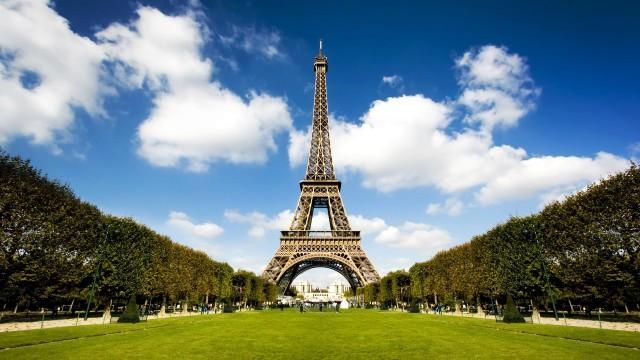

In [12]:
decryption_image_bytes_arrray = bytes( decryption_image_bytes_arrray ) # 转成bytes，Image.frombytes 不支持从 bytearray转成图片

decryption_image = Image.frombytes('L',(pic_width, pic_height ),bytes( decryption_image_bytes_arrray ))
decryption_image = Image.frombytes('RGB',(pic_width, pic_height ),bytes( decryption_image_bytes_arrray ))

display( decryption_image )

## 保存 相关 图片